In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD
from keras.layers import Conv1D, Flatten, LSTM, Reshape, BatchNormalization, Activation, UpSampling1D, ZeroPadding1D, PReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bd_data=[]
bv_data=[]
ba_data=[]
eq_data=[]
list1=os.listdir(r"/content/drive/MyDrive/Major Project/New/Data/dat2")
for filename in list1:
  filepath=os.path.join(r"/content/drive/MyDrive/Major Project/New/Data/dat2",filename)
  for i in os.listdir(filepath):
    if i.startswith('DFree'):
      disp=np.genfromtxt(os.path.join(filepath,i),skip_header=10,usecols=(1,2,3,4,5,6))
      disp=disp[0:800,:]
      bd_data.append(disp)
    if i.startswith('VFree'):
      vel=np.genfromtxt(os.path.join(filepath,i),skip_header=10,usecols=(1,2,3,4,5,6))
      vel=vel[0:800,:]
      bv_data.append(vel)
    if i.startswith('AFree'):
      acel=np.genfromtxt(os.path.join(filepath,i),skip_header=10,usecols=(1,2,3,4,5,6))
      acel=disp[0:800,:]
      ba_data.append(acel)

list2=os.listdir(r"/content/drive/MyDrive/Major Project/New/Data/earth_quake2/EQ")
for filename in list2:
  filepath=os.path.join(r"/content/drive/MyDrive/Major Project/New/Data/earth_quake2/EQ",filename)
  eq=np.genfromtxt(filepath)
  eq=eq[0:800,]
  eq_data.append(eq)

bd_data=np.array(bd_data)
bv_data=np.array(bv_data)
ba_data=np.array(ba_data)    
eq_data=np.array(eq_data)      
eq_data=eq_data.reshape(20,800,1)      
      


In [5]:
print(f"Shape of displacement data loaded is\t\t {bd_data.shape}")
print(f"Shape of velocity data loaded is\t\t {bv_data.shape}")
print(f"Shape of accelaration data loaded is\t\t {ba_data.shape}")
print(f"Shape of ground accelaration data loaded is\t {eq_data.shape}")


Shape of displacement data loaded is		 (20, 800, 6)
Shape of velocity data loaded is		 (20, 800, 6)
Shape of accelaration data loaded is		 (20, 800, 6)
Shape of ground accelaration data loaded is	 (20, 800, 1)


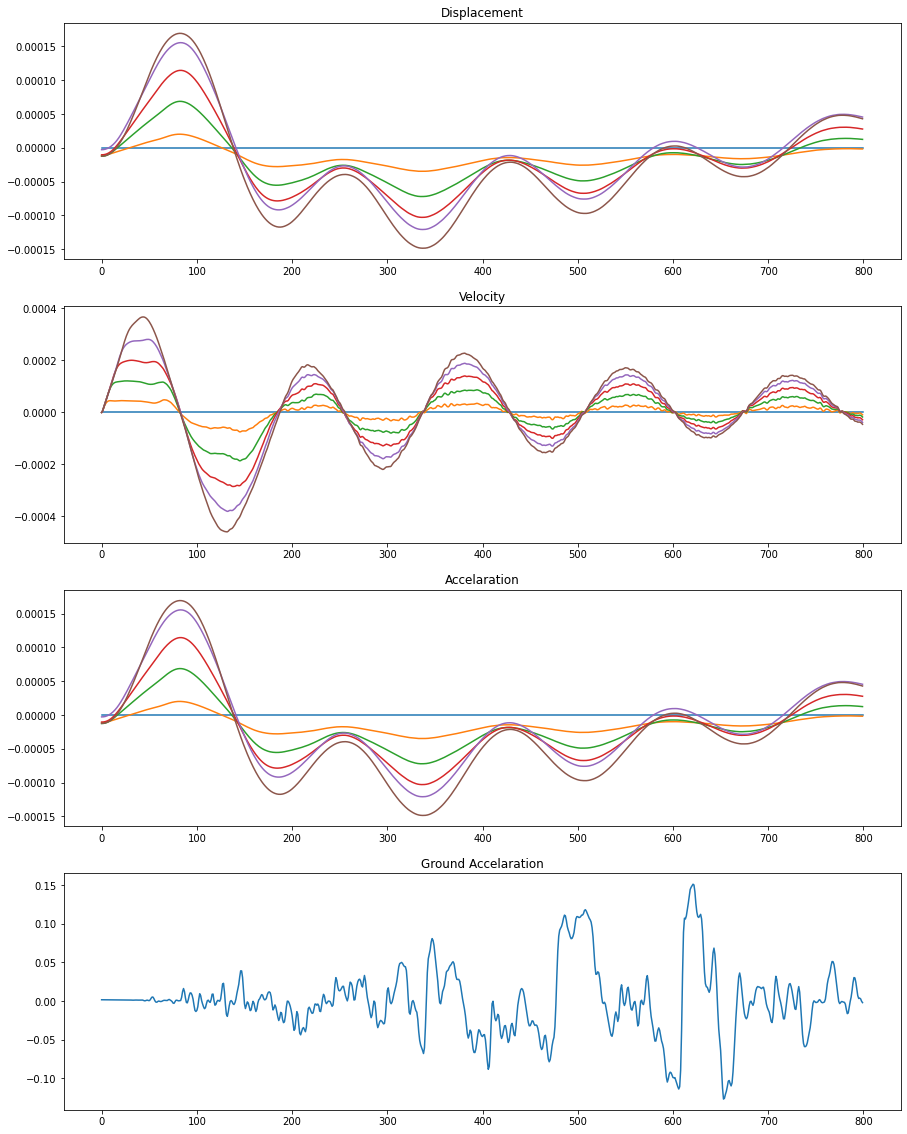

In [6]:
fig=plt.figure(figsize=(15,20))
ax1=plt.subplot(4,1,1)
ax1.set_title("Displacement")
ax1.plot(bd_data[1,:,:])
ax2=plt.subplot(4,1,2)
ax2.set_title("Velocity")
ax2.plot(bv_data[1,:,:])
ax3=plt.subplot(4,1,3)
ax3.set_title("Accelaration")
ax3.plot(ba_data[1,:,:])
ax4=plt.subplot(4,1,4)
ax4.set_title("Ground Accelaration")
ax4.plot(eq_data[1,:,:])
plt.show()

In [21]:
class DeepPhyLSTM:
    # Initialize the class
    def __init__(self, eta_tt, ag, Phi_t):

        # data
        self.eta_tt = eta_tt
        self.ag = ag
        self.Phi_t = Phi_t

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # placeholders for data
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.eta_tt_tf = tf.placeholder(tf.float32, shape=[None, None, self.eta_tt.shape[2]])
        self.ag_tf = tf.placeholder(tf.float32, shape=[None, None, 1])

        # physics informed neural networks
        self.eta_pred, self.eta_t_pred, self.eta_tt_pred, = self.net_structure(self.ag_tf)

        # loss
        # for measurements
        self.loss = tf.reduce_mean(tf.square(self.eta_tt_tf - self.eta_tt_pred)) + tf.reduce_mean(tf.square(self.eta_pred[:,:,0:10]))

        # optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 20000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def CNN_model(self, X):
        model = Sequential()
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True, input_shape=(None, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(self.eta_tt.shape[2]))
        y = model(X)
        return y

    def net_structure(self, ag):
        eta = self.CNN_model(ag)

        Phi_ut = np.reshape(self.Phi_t, [1, self.eta_tt.shape[1], self.eta_tt.shape[1]])
        Phi_ut = np.repeat(Phi_ut, self.eta_tt.shape[0], axis=0)
        eta_t = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta)
        eta_tt = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta_t)

        return eta, eta_t, eta_tt
    
    def train(self, num_epochs, batch_size, learning_rate, bfgs):

        Loss = []

        for epoch in range(num_epochs):
            
            N = self.eta_tt.shape[0]

            start_time = time.time()
            for it in range(0, N, batch_size):
                tf_dict = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}
                self.sess.run(self.train_op, tf_dict)
                
                # Print
                if it % (10*batch_size) == 0:
                    elapsed = time.time() - start_time
                    loss_value, learning_rate_value = self.sess.run([self.loss, self.learning_rate], tf_dict)
                    print('Epoch: %d, It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e'
                          %(epoch, it/batch_size, loss_value, elapsed, learning_rate_value))
                    start_time = time.time()

            Loss.append(self.sess.run(self.loss, tf_dict))

        if bfgs == 1:
            tf_dict_all = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}

            self.optimizer.minimize(self.sess,
                                    feed_dict=tf_dict_all,
                                    fetches=[self.loss],
                                    loss_callback=self.callback)

            Loss.append(self.sess.run(self.loss, tf_dict))

        return Loss

    def callback(self, loss):
        print('Loss:', loss)

    def predict(self, ag_star):
        
        tf_dict = {self.ag_tf: ag_star}

        eta_star = self.sess.run(self.eta_pred, tf_dict)
        eta_t_star = self.sess.run(self.eta_t_pred, tf_dict)
        eta_tt_star = self.sess.run(self.eta_tt_pred, tf_dict)

        return eta_star, eta_t_star, eta_tt_star
    

In [22]:
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(eq_data,ba_data,test_size=0.25,random_state=None)

In [23]:
x_train=eq_data[0:15,:,:]
y_train=ba_data[0:15,:,5:]*1000
x_test=eq_data[15:20,:,:]
y_test=ba_data[15:20,:,5:]*1000

In [24]:
print(f"Shape of xtrain is\t\t {x_train.shape}")
print(f"Shape of ytrain is\t\t {y_train.shape}")
print(f"Shape of xtest is\t\t {x_test.shape}")
print(f"Shape of ytest is\t\t {y_test.shape}")

Shape of xtrain is		 (15, 800, 1)
Shape of ytrain is		 (15, 800, 1)
Shape of xtest is		 (5, 800, 1)
Shape of ytest is		 (5, 800, 1)


In [25]:
# if __name__ == "__main__":
#   # load data
#   dataDir = "/content/drive/MyDrive/phy/"
#   mat = scipy.io.loadmat(dataDir + 'data_SanBernardino.mat')

#   x_train = mat['input_tf'][:, 3000:3200]
#   x_train=x_train.reshape(15,200,1)
#   x_test=mat['input_pred_tf'][:, 3000:3200]
#   x_test=x_test.reshape(6,200,1)
  
#   y_train = mat['target_tf'][:,3000:3200,:]
#   y_train=y_train.reshape(15,200,2)
#   y_test=mat['target_pred_tf'][:,3000:3200]
#   y_test=y_test.reshape(6,200,2)

#   train_indices = mat['trainInd'] - 1
#   test_indices = mat['valInd'] - 1
 
#   #x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.9,random_state=None)

#   dt = 0.02
#     # finite difference
#   n = y_train.shape[1]
#   phi1 = np.concatenate([np.array([-3/ 2, 2, -1 / 2]), np.zeros([n - 3, ])])
#   temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
#   temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
#   phi2 = temp1 + temp2
#   phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
#   Phi_t = 1 / dt * np.concatenate(
#             [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
#   N_train = y_train.shape[0]

# **No need to run the above cell.**

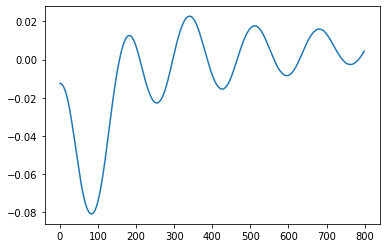

In [26]:
plt.figure()
plt.plot(y_train[4])

In [27]:
dt = 0.01
    # finite difference
n = y_train.shape[1]
phi1 = np.concatenate([np.array([-3/ 2, 2, -1 / 2]), np.zeros([n - 3, ])])
temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
Phi_t = 1 / dt * np.concatenate(
            [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
N_train = y_train.shape[0]

In [28]:

# Training
model = DeepPhyLSTM(y_train,x_train, Phi_t)

Loss = model.train(num_epochs=2000, batch_size=N_train, learning_rate=0.01, bfgs=1)

train_loss = Loss

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Epoch: 0, It: 0, Loss: 5.455e+03, Time: 1.86, Learning Rate: 1.000e-02
Epoch: 1, It: 0, Loss: 2.177e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 2, It: 0, Loss: 1.896e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 3, It: 0, Loss: 1.896e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 4, It: 0, Loss: 1.885e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 5, It: 0, Loss: 1.881e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 6, It: 0, Loss: 1.878e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 7, It: 0, Loss: 1.867e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 8, It: 0, Loss: 1.817e+03, Time: 0.02, Learning Rate: 1.000e-02
Epoch: 9, It: 0, Loss: 1.901e+03, Time: 0.01, Learning Rate: 1.000e-0

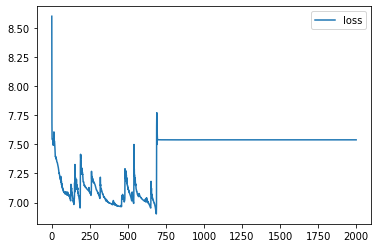

In [29]:
  plt.figure()
  plt.plot(np.log(train_loss), label='loss')
    # plt.plot(np.log(test_loss), label='loss_val')
  plt.legend()

In [30]:
eta, eta_t, eta_tt = model.predict(x_train)

In [31]:
eta_tt.shape

(15, 800, 1)

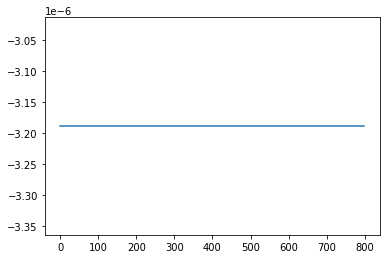

In [32]:
plt.figure()
# plt.plot(bd_data[1,:,5])
plt.plot(eta[1,:,:])
plt.show()

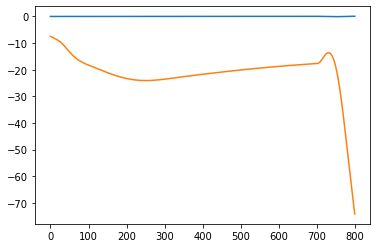

In [ ]:
x_test1=np.concatenate([x_test,x_test, x_test[0:3]], axis=0)[:, 0:1000, :]

In [ ]:
x_test1.shape

(13, 800, 1)

In [ ]:
eta, eta_t, eta_tt = model.predict(x_test1)

InvalidArgumentError: ignored

In [ ]:
def plott(x):
  plt.figure()
  plt.plot(y_test[x,:,0])
  
  plt.plot(eta_tt[x,:,0])

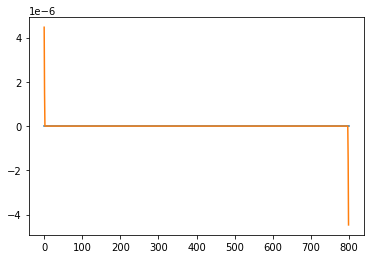

In [ ]:
plott(3)

In [ ]:
a=np.concatenate([np.zeros([1200,1]),y_test[0],np.zeros([1200,1])])

ValueError: ignored

In [ ]:
a.shape

NameError: ignored

In [ ]:
np.zeros([2400,1])

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

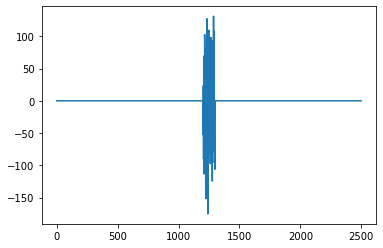

In [ ]:
plt.plot(a)